In [1]:
import json
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import make_circles

# Circles Example

In [3]:
data, target = make_circles(n_samples=500, noise=.05, factor=.5)

In [4]:
color = [["red", "blue"][elem] for elem in target]

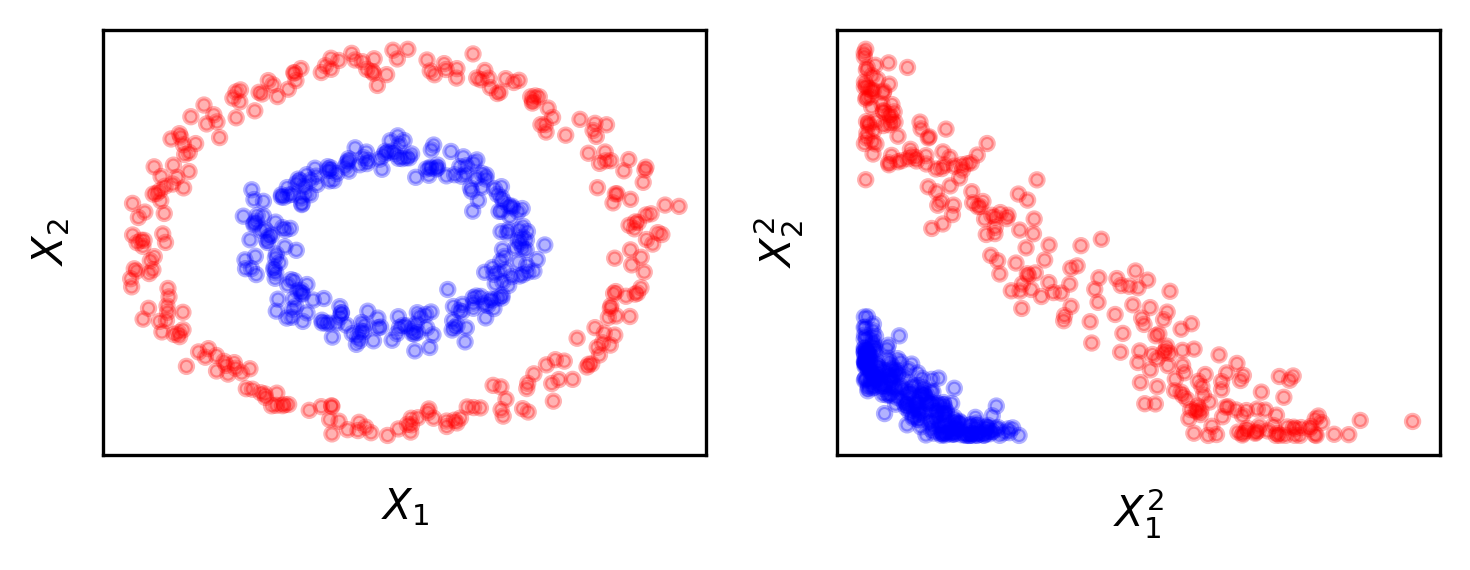

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2), dpi=300)
ax[0].scatter(data[:, 0], data[:, 1], color=color, alpha=.3, s=10)
ax[1].scatter(data[:, 0]**2, data[:, 1]**2, color=color, alpha=.3, s=10)

ax[0].set_yticks([])
ax[0].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticks([])

ax[0].set_xlabel("$X_1$")
ax[0].set_ylabel("$X_2$")

ax[1].set_xlabel("$X_1^2$")
ax[1].set_ylabel("$X_2^2$")

plt.tight_layout()
plt.savefig("circles.pdf")

# Default Metrics

In [8]:
from src.datasets import alldts
from src.metrics import cluster_evaluate

ModuleNotFoundError: No module named 'graph'

In [7]:
selection = {"cred_aus", "cred_ger", "breast_coimbra", "sonar", "heart"}
datasets = [(k, v) for k, v in alldts().items() if k in selection]

In [ ]:
aux = list()
for dataset_name, (data, target) in datasets:
    aux.append(dict({"dataset": dataset_name}, **cluster_evaluate(data, target)))

In [ ]:
pd.DataFrame(aux)

# Results

In [ ]:
files = glob("src/results/*.json")

aux = list()
for file in files:
    with open(file, "r") as f:
        aux.append(json.load(f))
df = pd.json_normalize(aux)

In [ ]:
df["acc_diff"] = (df["acc_test"] - df["acc_train"]).abs()

In [ ]:
colors = {
    "cred_ger": "red",
    "cred_aus": "blue",
    "breast_coimbra": "green",
    "heart": "black",
    "sonar": "purple",
}

In [ ]:
import matplotlib.patches as mpatches

In [ ]:
plt.figure(figsize=(6, 3), dpi=300)
ax = plt.gca()
df.plot.scatter(
    x="acc_diff", y="sil_neg_samples_score",
    c=df["dataset"].apply(lambda x: colors[x]),
    alpha=.5, ax=ax
)

plt.legend(handles=[mpatches.Patch(color=v, label=k) for k, v in colors.items()])
plt.tight_layout()
plt.savefig("silneg.pdf")

In [ ]:
df.corr(numeric_only=True)

In [ ]:
aux = list()
for name, group in df.groupby("dataset"):
    group["acc_diff"] = group["acc_test"] - group["acc_train"]
    for metric in ["silhouette_score", "sil_neg_samples_score", "calinski_harabasz_score", "davies_bouldin_score"]:
        aux.append({
            "dataset": name,
            "metric": metric,
            "coefs": {
                "acc_test": np.poly1d(np.polyfit(group["acc_test"], group[metric], 1)).coef[0],
                "acc_diff": np.poly1d(np.polyfit(group["acc_diff"], group[metric], 1)).coef[0],
                "alpha": np.poly1d(np.polyfit(group["alpha"], group[metric], 1)).coef[0],
                "best_loss": np.poly1d(np.polyfit(group["best_loss"], group[metric], 1)).coef[0],
            }
        })

In [ ]:
(
    pd.json_normalize(aux)
    .pivot(
        index="metric", columns="dataset",
        values=[
            "coefs.acc_test",
            "coefs.acc_diff",
            "coefs.alpha",
            "coefs.best_loss",
        ]
    )
)

In [ ]:
for name, group in df.groupby(["dataset", "alpha"], as_index=False).mean().groupby("dataset"):
    x = group["alpha"]
    poly_train = np.poly1d(np.polyfit(group["alpha"], group["acc_train"], 1))
    poly_test = np.poly1d(np.polyfit(group["alpha"], group["acc_test"], 1))

    plt.figure(figsize=(5, 2))
    ax = plt.gca()
    plt.plot(x, poly_train(x), label="train", color="blue")
    plt.plot(x, poly_test(x), label="test", color="red")
    plt.scatter(x, group["acc_train"], color="blue", alpha=.3)
    plt.scatter(x, group["acc_test"], color="red", alpha=.3)
    plt.legend()
    plt.title(name)
    plt.tight_layout()
    plt.show()
    plt.close()

---